# Decision Tree Classifier
# Practical Machine Learning Tutorial with Python
## Implementing some functions of the subject practical work

## t3: Load the data into a bidimensional list.
### Return the headers as a list, and the data

In [2]:
from typing import Tuple, List, Optional, Type, Any, Dict

file_path = "../../resources/lab/decision_tree_example.txt"

ColumnHeader: Type = List[str]
Row: Type = List[int | float | str]
MatrixData: Type = List[Row]

def read_data(file_name: str, separator: str = ",") -> Tuple[ColumnHeader, MatrixData]:
    """
    t3: Load the data into a bidimensional list.
    Return the headers as a list, and the data
    """
    header: Optional[ColumnHeader]= None
    dataset: MatrixData = []
   
    with open(file_name, "r") as fh:
    # Contex manager:
    # It ensures that the file is properly opened and closed, even if an exception occurs during the file operations.
        for line in fh:
            values = line.strip().split(separator)
            # Getting the header of the file
            if header is None:
                header = values
            else:
                dataset.append([_parse_value(v) for v in values])
    return header, dataset


def _parse_value(v: str) -> int | float | str:
    """ Auxiliary function to parser numerical values from text"""
    try:
        _v = float(v)
        if _v == int(_v):
            return int(v)
        else:
            return float(v)
    except ValueError:
        # is not a numerical, thus, is a categorical value
        return v


# Testing **********************************************
header, dataset = read_data(file_path, separator=",")
# print(type(dataset[0][3]))
print(f"Loaded {len(dataset)} samples: {len(dataset[0])-1} features and 1 class")
# header, dataset

Loaded 16 samples: 4 features and 1 class


## Analyzing the dataset with Pandas framework

In [3]:
import pandas as pd

ds = pd.read_csv(file_path, sep=",")
ds

,Referrer,Location,ReadFAQ,Pagesviewed,Service
0,slashdot,USA,yes,18,NaN
1,google,France,yes,23,Premium
2,digg,USA,yes,24,Basic
3,kiwitobes,France,yes,23,Basic
4,google,UK,no,21,Premium
5,(direct),NewZealand,no,12,NaN
6,(direct),UK,no,21,Basic
7,google,USA,no,24,Premium
8,slashdot,France,yes,19,NaN
9,digg,USA,no,18,NaN


In [120]:
ds.describe()

,Pagesviewed
count,16.000000
mean,19.375000
std,3.593976
min,12.000000
25%,18.000000
50%,19.000000
75%,21.500000
max,24.000000


In [121]:
ds.dtypes

Referrer       object
Location       object
ReadFAQ        object
Pagesviewed     int64
Service        object
dtype: object

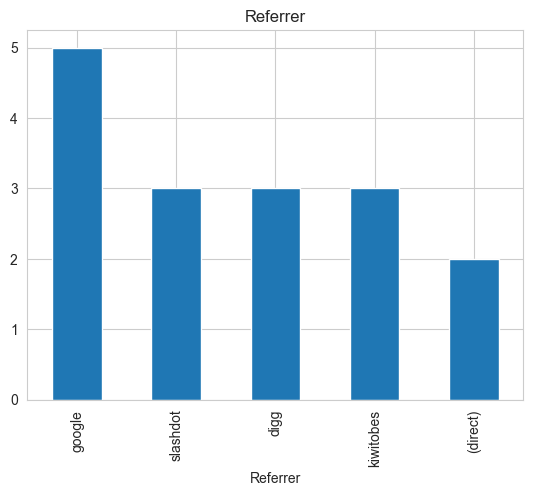

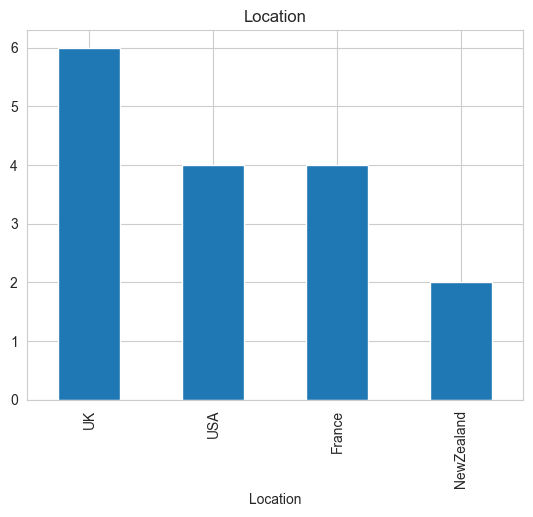

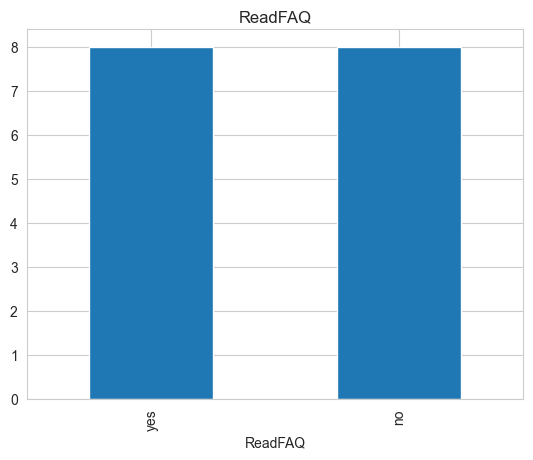

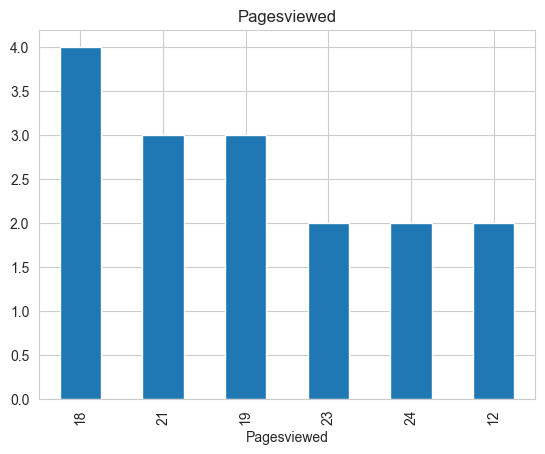

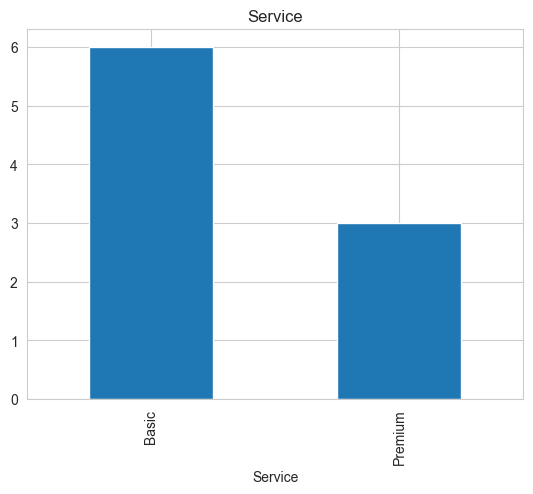

In [122]:
# Showing histograms for each feature
import matplotlib.pyplot as plt
for column in ds.columns:
    ds[column].value_counts().plot(kind='bar', title=column)
    plt.show()

## Prepare class labels to avoid NaN values

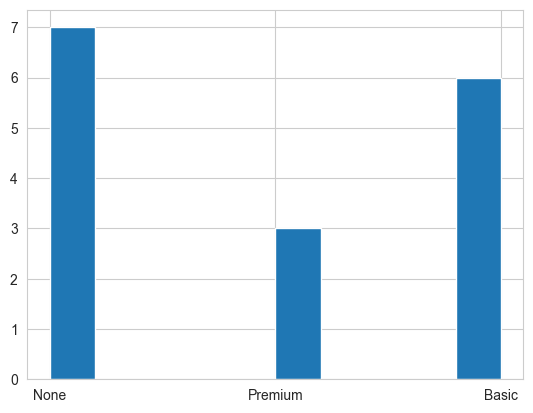

Service
None       7
Basic      6
Premium    3
Name: count, dtype: int64

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a None category to replace NaN values
no_value= "None"

ds.Service.replace(np.nan, no_value).hist()
plt.show()

ds.Service.replace(np.nan, no_value).value_counts()

<Axes: >

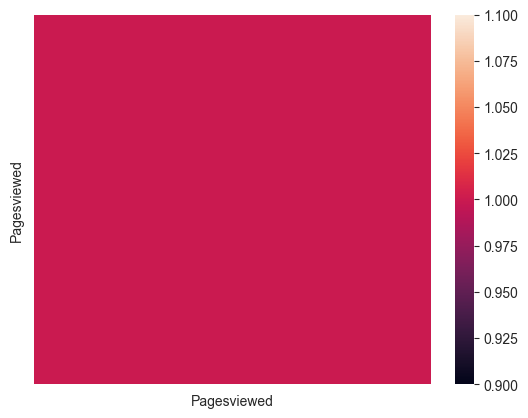

In [6]:
import seaborn as sns

# Assuming 'Species' is the last column
numerical_columns = ds.select_dtypes(include=['float64', 'int64']).columns
numerical_data = ds[numerical_columns]

# Compute the correlation matrix
corr = numerical_data.corr()

# Important: 'corr' contains the correlation matrix excluding the categorical column
corr = numerical_data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


# t4: Create counts of possible results
## the last column of each row is the result


In [21]:
import collections

def unique_counts(part: MatrixData) -> Dict[Any, int]:
    """
    t4: Create counts of possible results
    (the last column of each row is the result)
     """
    
    # print(f"{part=}")
    # print(f"{[row[-1] for row in part]}")
    return dict(collections.Counter(row[-1] for row in part))
 
# Testing **********************************************    

unique_counts(dataset[:])
# Playing with the number of dataset's samples
# unique_counts(dataset[:5])

{'None': 7, 'Premium': 3, 'Basic': 6}

# t5: Computes the Gini index of a node.
### Gini Impurity Calculation

### The Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
### A Gini index of 0 represents perfect purity (all elements belong to a single class).
### A Gini index of 1 represents maximum impurity (the elements are evenly distributed across all classes)

The Gini impurity of a node can be computed using the following formula:
#### Impurity = $ 1 - \sum_{i} \left(\frac{{v_i}}{{\text{{total}}}}\right)^2 $
where:
$ - v_i\ $ is the count of instances for class \(i\),
$ - total $  is the total number of instances in the node.


In [22]:
def gini_impurity(part: MatrixData) -> float:
    """
    Computes the Gini index of a node
    """
    total = len(part)
    if total == 0:
        return 0

    results = unique_counts(part)

    imp = 1 - sum((v / total) ** 2 for v in results.values())
    
    return imp

# Testing **********************************************
gini_impurity(dataset[:])
# Playing with the number of dataset's samples
# gini_impurity(dataset[:5])

0.6328125

# t6: Compute the Entropy on a node

### Entropy is a measure of uncertainty associated with a given state. It is commonly used in machine learning for measuring the impurity in a given node of the decision tree.
### Zero represents perfect classification or no impurity. Higher entropy values signify greater disorder or impurity in the node the classes.

### Entropy = $ - \sum_{i=1}^{n} p_i \cdot \log_2(p_i) $

#### where pi is the probability of class i in the node. $ p_i = \frac{{v_i}}{{\text{{total}}}} $

In [23]:
from math import log2


def entropy(part: MatrixData) -> float:
    """
    t6: Entropy is the sum of p(x)log(p(x))
    across all the different possible results
    """
    total = len(part)
    results = unique_counts(part)
    
    probs = [v / total for v in results.values()]
    
    # Checking intermediate results
    for p in probs:
        print(f"{p=}")
        print(f"{log2(p)=}")
        print(f"{p * log2(p)}\n")
    
    return -sum(p * log2(p) for p in probs)

# Testing **********************************************
entropy(dataset[:])
# Playing with the number of dataset's samples
# entropy(dataset[:5])

p=0.4375
log2(p)=-1.1926450779423958
-0.5217822215997981

p=0.1875
log2(p)=-2.415037499278844
-0.45281953111478324

p=0.375
log2(p)=-1.415037499278844
-0.5306390622295665


1.5052408149441479

 #  t7: Divide a set on a specific column. Can handle numeric or categorical values

In [24]:
# Auxiliary function to split the dataset
def _split_numeric(prototype: List, column: int, value):
    """
   Implement the split logic for int variables
   """
    return prototype[column] >= value


def _split_categorical(prototype: List, column: int, value: str):
    """
    Implement the split logic for categorical variables
    """
    return prototype[column] == value


def divideset(part: MatrixData, column: int, value) -> Tuple[MatrixData, MatrixData]:
    """
    t7: Divide a set on a specific column. Can handle
    numeric or categorical values
    """
    if isinstance(value, (int, float)):
        split_function = _split_numeric
    else:
        split_function = _split_categorical

    set1 = [row for row in part if split_function(row, column, value)]
    set2 = [row for row in part if not split_function(row, column, value)]

    return set1, set2


# Testing **********************************************
for col in range(len(dataset[0]) - 1):  # Exclude the last column (result)
    unique_values = set(row[col] for row in dataset)
    for value in unique_values:
        set1, set2 = divideset(dataset, col, value)
        
set1, set2

([['digg', 'USA', 'yes', 24, 'Basic'], ['google', 'USA', 'no', 24, 'Premium']],
 [['slashdot', 'USA', 'yes', 18, 'None'],
  ['google', 'France', 'yes', 23, 'Premium'],
  ['kiwitobes', 'France', 'yes', 23, 'Basic'],
  ['google', 'UK', 'no', 21, 'Premium'],
  ['(direct)', 'NewZealand', 'no', 12, 'None'],
  ['(direct)', 'UK', 'no', 21, 'Basic'],
  ['slashdot', 'France', 'yes', 19, 'None'],
  ['digg', 'USA', 'no', 18, 'None'],
  ['google', 'UK', 'no', 18, 'None'],
  ['kiwitobes', 'UK', 'no', 19, 'None'],
  ['digg', 'NewZealand', 'yes', 12, 'Basic'],
  ['slashdot', 'UK', 'no', 21, 'None'],
  ['google', 'UK', 'yes', 18, 'Basic'],
  ['kiwitobes', 'France', 'yes', 19, 'Basic']])

# DecisionTree Classifier with Sckit-Learn

iris.data.shape=(150, 4)
iris.target.shape=(150,)


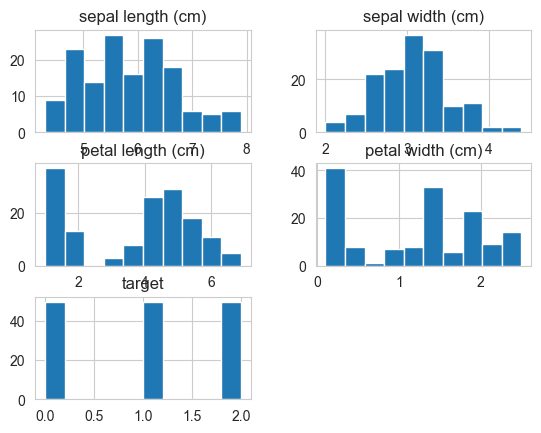

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score

iris = load_iris()
print(f"{iris.data.shape=}")
print(f"{iris.target.shape=}")

ds = pd.DataFrame(data= np.c_[iris.data, iris.target],
                  columns= iris['feature_names'] + ['target'])

ds.hist()
# plt.gcf().set_size_inches(15, 15)  # Adjust dimensions as needed
plt.show()

ds.target.value_counts()

## Split the dataset into training and test sets
### Training de model with 80% of the data and testing with the remaining 20%

### Play with the hyperparameters to see how they affect the model accuracy

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data,
    iris.target,
    random_state=42,
    test_size=0.2,
    # stratify=iris.target
)

# Create a decision tree classifier
clf = DecisionTreeClassifier(
    # **** Hyper-parameters tuning ***
    criterion="entropy", # "gini", # entropy
    # ** Pruning **
    # max_depth=3,
    # min_samples_leaf=20,
    # min_samples_split=20
    random_state=42)

# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

## Feature importance

In [16]:
clf.feature_importances_

feature_importances = dict(zip(iris.feature_names, clf.feature_importances_))

print("Feature Importances:")
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Feature Importances:
sepal length (cm): 0.0
sepal width (cm): 0.014487251656875581
petal length (cm): 0.8954057704812955
petal width (cm): 0.09010697786182895


## Calculate and display the model accuracy on the test set

In [17]:
# Calculate and display the model accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 1.0


## Let's show the decision tree in a text/graphical way

### Pay attention that a feature can be used more than once in the decision tree. However, it can not be used in the same path.
### This justifies the dependency of the tree structure in regards of the data used to train the model.

In [18]:
# Display the decision tree in text format
tree_rules = export_text(clf, feature_names=iris.feature_names)

print(tree_rules)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.75
|   |   |--- petal width (cm) <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  4.75
|   |   |--- petal width (cm) <= 1.75
|   |   |   |--- petal length (cm) <= 4.95
|   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  4.95
|   |   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  1.75
|   |   |   |--- petal length (cm) <= 4.85
|   |   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |   |--- class: 1
|   |   |   |--- petal 

## Visualize the decision tree using Graphviz
### Need to install Graphviz (https://graphviz.org/download/)

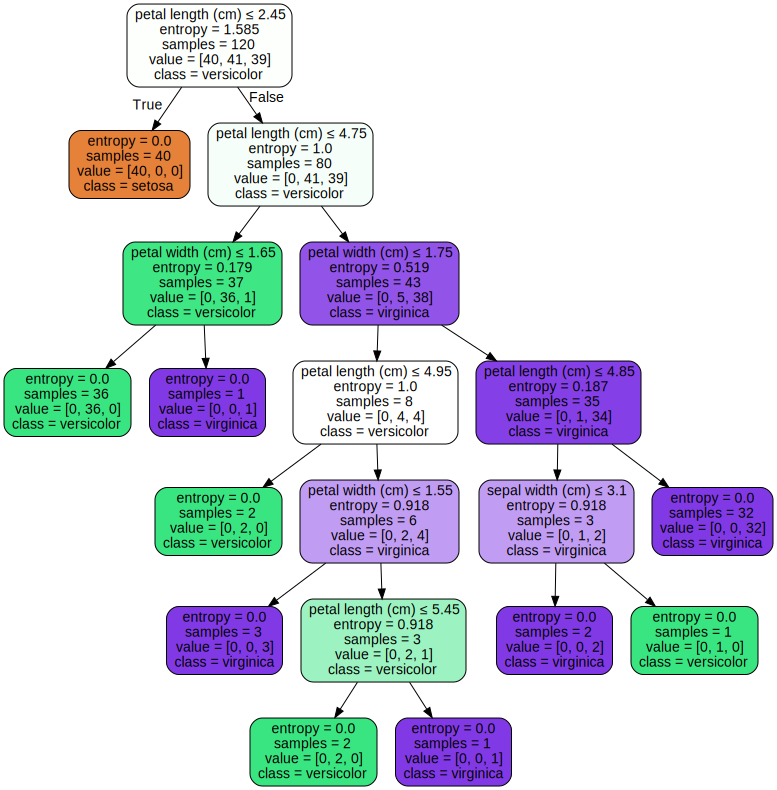

In [19]:
# Visualize the decision tree using Graphviz
dot_data = tree.export_graphviz(
    clf, out_file=None, 
    feature_names=iris.feature_names, 
    class_names=iris.target_names, filled=True, rounded=True, special_characters=True
)
graph = graphviz.Source(dot_data)
graph

In [20]:
# Save the graph
graph.format = 'png'  # specify the output format
graph.render(filename='decision_tree_graph', directory='.', cleanup=True)

'decision_tree_graph.png'